In [1]:
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib.pyplot as plt

from qiskit import Aer

from qiskit_finance.applications.ising.portfolio import Portfolio
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import CplexOptimizer, OptimizationResult

In [2]:
# set number of assets (= number of qubits)
num_assets = 4

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(2016,1,1),
                 end=datetime.datetime(2016,1,30), seed=123)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
q = 0.5                   # set risk factor
budget = num_assets // 2  # set budget

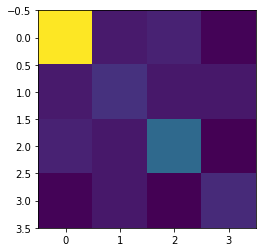

[[ 2.54138859e-03  7.34022167e-05  1.28600531e-04 -9.98612132e-05]
 [ 7.34022167e-05  2.58486713e-04  5.30427595e-05  4.44816208e-05]
 [ 1.28600531e-04  5.30427595e-05  7.91504681e-04 -1.23887382e-04]
 [-9.98612132e-05  4.44816208e-05 -1.23887382e-04  1.97892585e-04]]


In [3]:
# plot sigma
plt.imshow(sigma, interpolation='nearest')
plt.show()
print(sigma)

In [4]:
portfolio = Portfolio(mu, sigma, q, budget)

In [5]:
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: portfolio

Minimize
 obj: 0.015284386652 x_0 - 0.000780952145 x_1 + 0.000517920547 x_2
      + 0.000870005837 x_3 + [ 0.002541388592 x_0^2 + 0.000146804433 x_0*x_1
      + 0.000257201062 x_0*x_2 - 0.000199722426 x_0*x_3 + 0.000258486713 x_1^2
      + 0.000106085519 x_1*x_2 + 0.000088963242 x_1*x_3 + 0.000791504681 x_2^2
      - 0.000247774763 x_2*x_3 + 0.000197892585 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End

In [6]:
optimizer = CplexOptimizer()
result = optimizer.solve(qp)
result

optimal function value: 0.0003150068582083353
optimal value: [0. 1. 1. 0.]
status: SUCCESS

In [7]:
print(portfolio.interpret(result))
print(portfolio.evaluate(result))


[0. 1. 1. 0.]
0.0003150068582083353


In [8]:
# burteforce-check the assignment gives the minimum value or not   
for i in range(num_assets):
    for j in range(i+1, num_assets):
        x = [0, 0, 0, 0]
        x[i] = 1
        x[j] = 1
        print(i, j)
        t_result=OptimizationResult(x, result.fval, result.variables, result.status)
        print(portfolio.evaluate(t_result))

0 1
0.015976774375804706
0 2
0.01759735436596769
0 3
0.01742417186447133
1 2
0.0003150068582083353
1 3
0.00036172496209949275
2 3
0.001758737635625786


In [9]:
print(portfolio.portfolio_expected_value(result))

print(portfolio.portfolio_variance(result))


-0.0002630315984469199
0.0011560769133105104
